# 1.데이터 취합 자동화


In [1]:
import re
import time
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import tqdm
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

#당일 시가 정보 불러오기
def find_gap(stock_code):
        time.sleep(0.05)
        URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-time-itemchartprice'

        headers = {"Content-Type":"application/json; charset=utf-8", 
                "authorization": f"Bearer {ACCESS_TOKEN}",
                "appKey":APP_KEY,
                "appSecret":APP_SECRET,
                "tr_id":"FHPST01060000"
                }

        params =  {
                "fid_cond_mrkt_div_code": "J",
                "fid_input_hour_1": "090030",
                "fid_input_iscd": stock_code
        }

        res = requests.get(URL, headers=headers, params=params)
        return res

#주식시세
def get_daily_info(stock_code):
    #api호출
    time.sleep(0.05)
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST01010400"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":f'{stock_code}',
        "fid_org_adj_prc": "0",
        "fid_period_div_code": "D"
    }
    #거래량, 저가 호출
    res = requests.get(URL, headers=headers, params=params)   
    res = res.json()
    res = res.get('output')[0:11]
    res.reverse()

    temp = pd.DataFrame(res).T
    temp.columns = [f'D_{i}' for i in range(10,-1,-1)]

    #당일 시가 및 고가
    daily_table = pd.DataFrame({
              'stck_oprc' :  temp['D_0']['stck_oprc'],
              'stck_hgpr'  : temp['D_0']['stck_hgpr'],
              },index=[0])
    
    #전일 저가,거래량(1일)
    b = ['stck_lwpr','acml_vol']
    for div in b:
        a = np.where(temp.index == f'{div}')[0][0]
        bin_table = temp.iloc[a:a+1,:].reset_index(drop=True)
        bin_table.columns = f'{div}_' + bin_table.columns
        daily_table = pd.concat([daily_table,bin_table],axis=1)

    return daily_table

#날짜호출
def get_date_info(stock_code):
    #api호출
    time.sleep(0.05)
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST01010400"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":f'{stock_code}',
        "fid_org_adj_prc": "0",
        "fid_period_div_code": "D"
    }
    #거래량, 저가 호출
    res = requests.get(URL, headers=headers, params=params)   
    res = res.json()
    date=res.get('output')[0].get('stck_bsop_date')

    return date

#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

#주가 기본정보 불러오기
Kospi_df = pd.read_csv('data/kospi_code.csv')
Kosdaq_df = pd.read_csv('data/kosdaq_code.csv')
#코스피 분류
kospi = Kospi_df.filter(items= ['단축코드','한글명'])
kospi['class'] = 'kospi'
#코스닥 분류
kosdaq = Kosdaq_df.filter(items= ['단축코드','한글종목명'])
kosdaq['class'] = 'kospi'
#주가 종목코드 불러오기
kospi = kospi.rename(columns={'단축코드':'stock_code','한글명' : 'stock_name'})
kosdaq = kosdaq.rename(columns={'단축코드':'stock_code','한글종목명' : 'stock_name'})
kospi_kosdaq = pd.concat([kospi,kosdaq])
kospi_kosdaq = kospi_kosdaq.reset_index(drop=True)

#개장 직후 종목 검색
data = pd.DataFrame()
for i in range(len(kospi_kosdaq)):
    stock_code = kospi_kosdaq.stock_code[i]
    stock_name = kospi_kosdaq.stock_name[i]
    res = find_gap(stock_code)
    try : 
        gap_per = res.json().get('output2')[-1].get('prdy_ctrt')
        gap_hour = res.json().get('output2')[-1].get('stck_cntg_hour')
        temp = pd.DataFrame({
                        'stock_code': stock_code,
                        'stock_name': stock_name,
                        'gap_per': gap_per,
                        'gap_hour': gap_hour,
                        }, index=[0])
        data = pd.concat([data,temp],axis=0)
    except :
        pass
data = data.reset_index(drop=True)
data['gap_int'] = data.gap_per.apply(lambda x: float(x))
stock2 = data.query('gap_int >= 2.0').reset_index(drop=True)

#종목별 정보 받아오기
daily_stock = pd.DataFrame()
for i in stock2.stock_code:
    daily_table = get_daily_info(i)
    daily_stock = pd.concat([daily_stock, daily_table])

#전체 합치기
daily_stock = daily_stock.reset_index(drop=True)
stock2 = pd.concat([stock2,daily_stock],axis=1)

#날짜호출
date = get_date_info(stock_code)

#데이터 인트타입으로 변환
for cn in stock2.columns[5:]:
    stock2[f'{cn}'] = stock2[f'{cn}'].apply(lambda x : int(x))

#증가율
stock2['gap_change'] = stock2['gap_int']

#거래량추이
ex_volume = stock2.iloc[:,18:28]

#이상치 범위 설정 
q3 = ex_volume.quantile(0.75, axis=1)
q1 = ex_volume.quantile(0.25, axis=1)

IQR = q3-q1
upper_limit = q3 + 1.5*IQR

#이상치 범위 변환
upper_limit = pd.DataFrame(upper_limit).to_numpy()
ex_volume = ex_volume.to_numpy()
ex_volume = np.where(ex_volume>upper_limit,np.nan,ex_volume)
ex_volume = pd.DataFrame(ex_volume)
stock2['mean_vlome'] = ex_volume.mean(axis=1)
stock2['today_vlome'] = stock2.acml_vol_D_0.apply(lambda x : int(x))
stock2['volume_change'] = stock2.iloc[:,28:].pct_change(axis=1)['today_vlome']

#저점 상승도
parameter = stock2.iloc[:,5:15]
parameter = parameter.T

for i in range(len(parameter.columns)):
    name = f'price{i}' 
    parameter = parameter.rename(columns={i:name})

parameter = parameter.reset_index().drop(columns=['index'])
parameter = parameter.reset_index()

data2=pd.DataFrame()
for i in range(0,len(stock2)):
    model = sm.OLS.from_formula(f'index ~ price{i}', parameter).fit()
    slope = model.params[f'price{i}']
    temp = pd.DataFrame({'slope': slope} ,index =[i])
    data2 = pd.concat([data2,temp])
stock2['slope'] = data2

#상승여부 판단
stock2['day_change'] = stock2['stck_hgpr'] - stock2['stck_oprc']
stock2['deter_change'] = stock2.day_change.apply(lambda x : 1 if x > 0 else 0)

#데이터저장
stock2.to_csv(f'./data/{date}.csv', index=False, encoding='utf-8-sig')

# 2.결과해석(당일)

[     gap_change    mean_vlome  today_vlome  volume_change     slope  \
0          2.59  7.223000e+02          761       0.053579 -0.001555   
1          2.50  5.769667e+03         8895       0.541684 -0.019091   
2          5.05  8.091009e+05      2321332       1.869027 -0.000681   
3          3.08  2.778548e+05      1279602       3.605291 -0.006947   
4          3.65  9.561700e+03        14587       0.525566 -0.007783   
..          ...           ...          ...            ...       ...   
122        2.25  7.873600e+04       378792       3.810912 -0.001766   
123        5.73  3.618316e+05      1123362       2.104654 -0.003182   
124        3.66  3.325188e+06      3449832       0.037485 -0.001041   
125        2.15  3.977720e+05       367741      -0.075498  0.000076   
126        2.09  1.040096e+05       257421       1.474973  0.012728   

     day_change  deter_change  
0             0             0  
1             0             0  
2           330             1  
3             0   

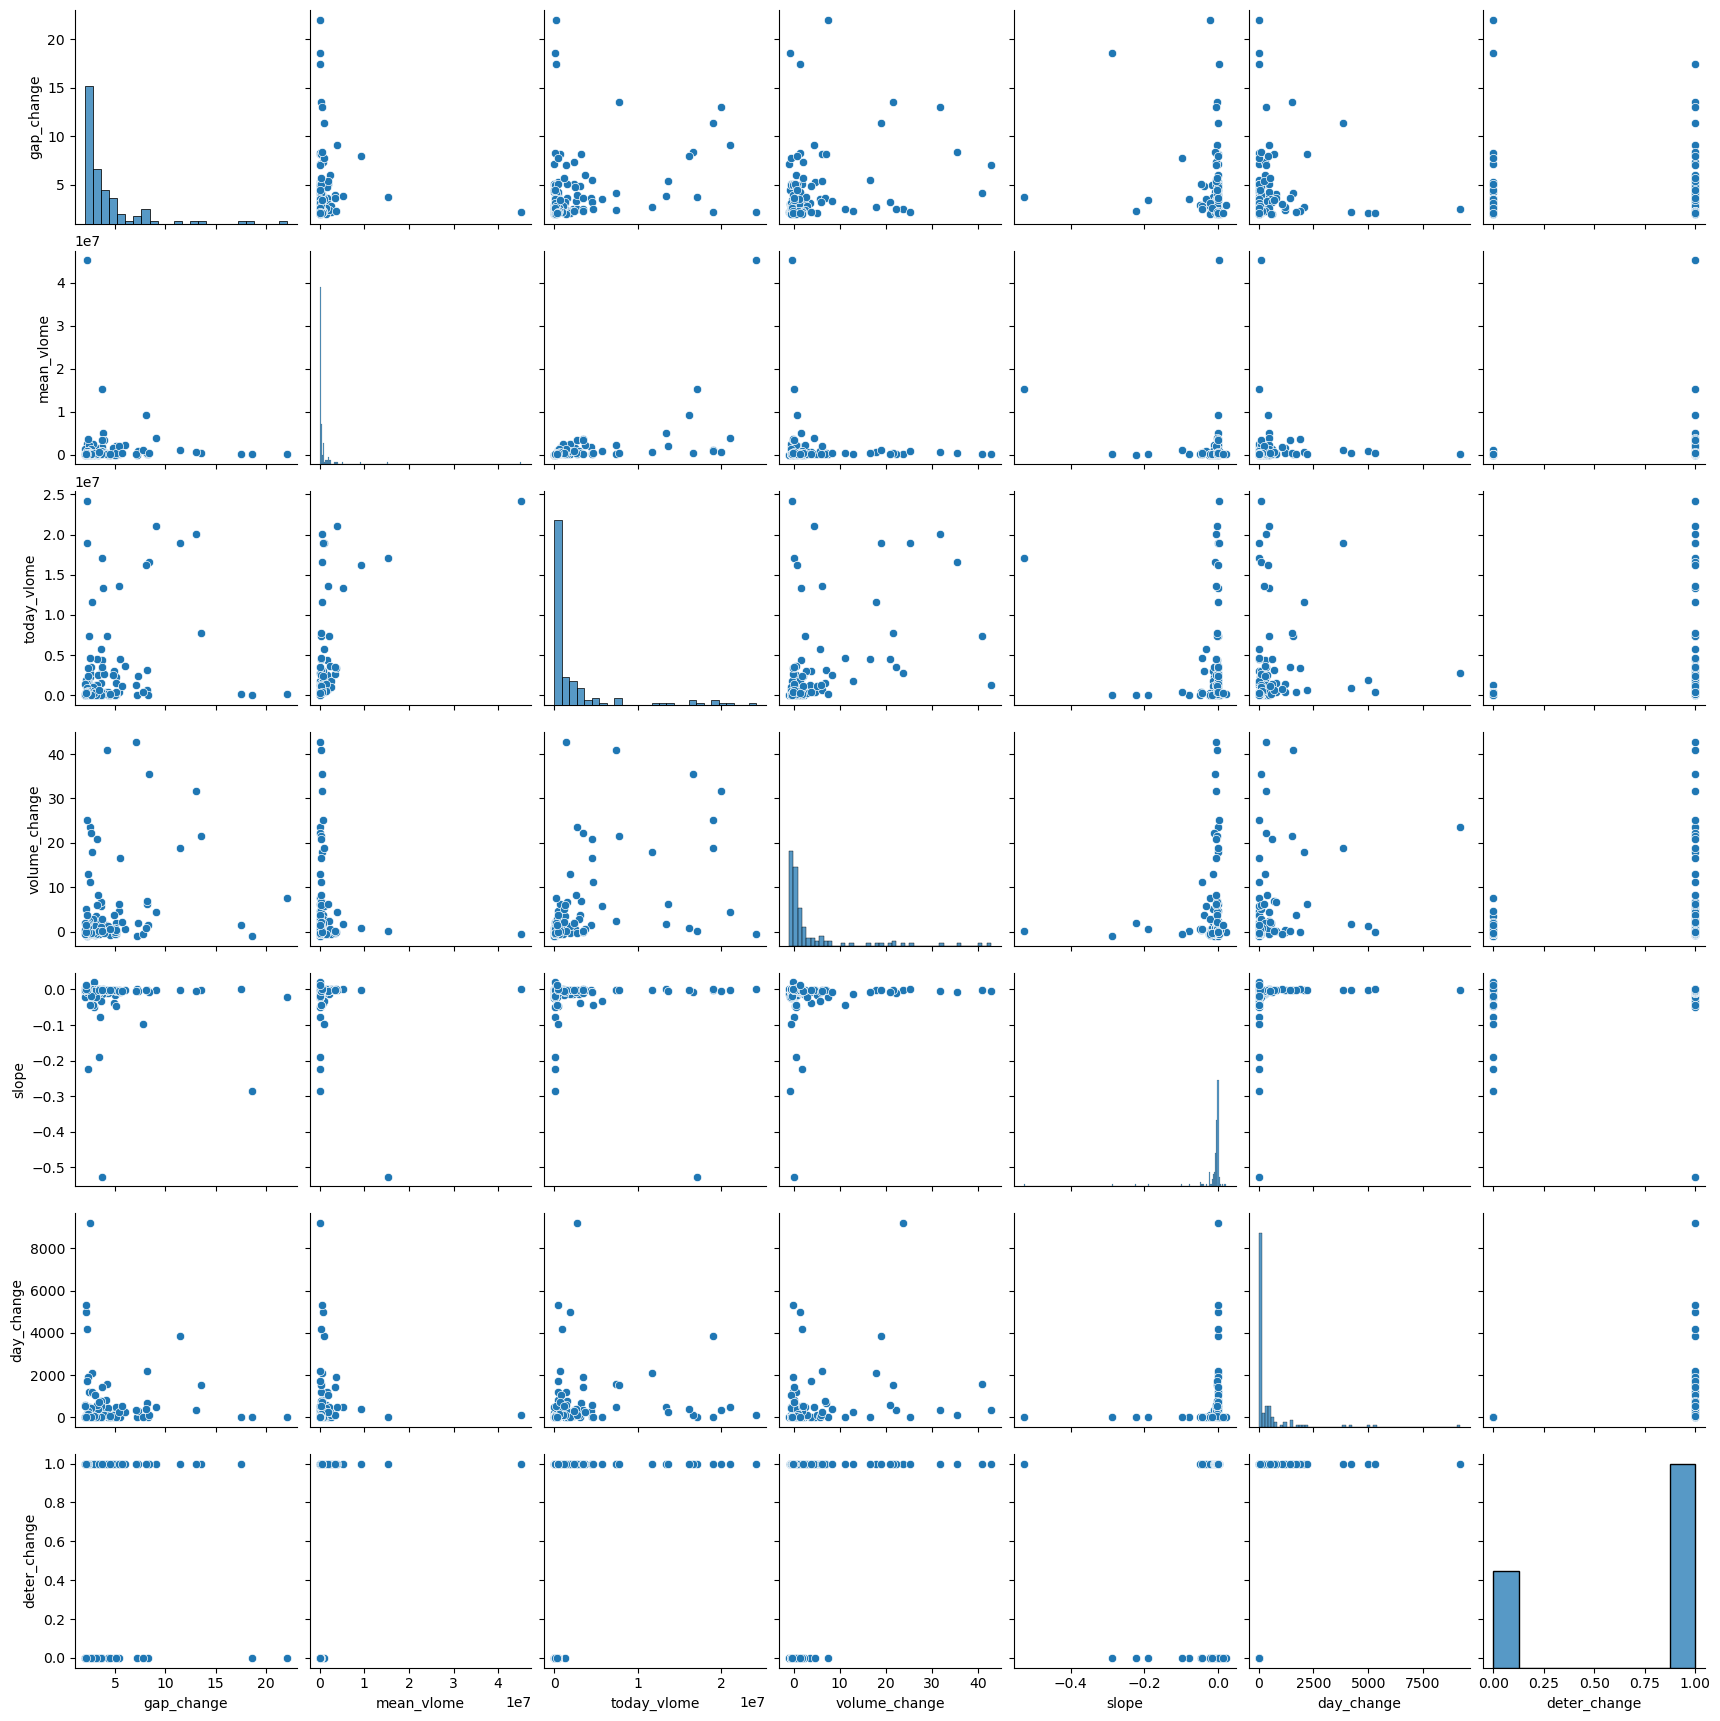

In [7]:
stock_data = stock2.iloc[:,29:]
print([stock_data])

%matplotlib inline
sns.pairplot(stock_data)



In [8]:
Y = stock_data['deter_change']
X = stock_data[['gap_change', 'mean_vlome', 'today_vlome', 'volume_change', 'slope']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.360322
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  127
Model:                          Logit   Df Residuals:                      121
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.4271
Time:                        17:24:17   Log-Likelihood:                -45.761
converged:                       True   LL-Null:                       -79.881
Covariance Type:            nonrobust   LLR p-value:                 2.380e-13
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1351      0.436     -0.310      0.757      -0.989       0.719
gap_change       -0

In [17]:
Y = stock_data['deter_change']
X = stock_data[['today_vlome', 'slope']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.368810
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  127
Model:                          Logit   Df Residuals:                      124
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.4136
Time:                        17:26:48   Log-Likelihood:                -46.839
converged:                       True   LL-Null:                       -79.881
Covariance Type:            nonrobust   LLR p-value:                 4.465e-15
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1675      0.324     -0.517      0.605      -0.803       0.468
today_vlome   3.57e-06   

# 3.결과해석(누적)

In [18]:
stock1 = pd.read_csv('data/20230308.csv')

In [19]:
stock = pd.concat([stock1,stock2])
stock

,stock_code,stock_name,gap_per,gap_hour,gap_int,stck_oprc,stck_hgpr,stck_lwpr_D_10,stck_lwpr_D_9,stck_lwpr_D_8,...,acml_vol_D_2,acml_vol_D_1,acml_vol_D_0,gap_change,mean_vlome,today_vlome,volume_change,slope,day_change,deter_change
0,000545,흥국화재우,2.6,90013,2.60,7100,7100,6710,6730,6800,...,4191,846,4008,2.00,3.765600e+03,4008,0.064372,0.004595,0,0
1,001390,KG케미칼,3.15,90029,3.15,34350,35600,24450,23400,23400,...,170560,3990677,3728552,3.00,1.125631e+05,3728552,32.124102,-0.000425,1250,1
2,006220,제주은행,7.26,90030,7.26,23250,23800,21950,22000,21200,...,677734,2278055,2196036,7.00,1.938465e+06,2196036,0.132874,-0.002273,550,1
3,006570,대림통상,3.09,90029,3.09,4005,5050,3870,3830,3750,...,5322,5748,1334669,3.00,5.073500e+03,1334669,262.066719,-0.003861,1045,1
4,017040,광명전기,3.85,90025,3.85,2595,2650,2395,2360,2370,...,439264,1245182,6365970,3.00,3.402592e+05,6365970,17.709177,-0.018137,55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,382900,범한퓨얼셀,2.25,090019,2.25,29500,31200,28100,28350,28650,...,119954,67022,378792,2.25,7.873600e+04,378792,3.810912,-0.001766,1700,1
123,383930,디티앤씨알오,5.73,090029,5.73,6890,7400,5750,5675,5800,...,512304,554700,1123362,5.73,3.618316e+05,1123362,2.104654,-0.003182,510,1
124,394280,오픈엣지테크놀로지,3.66,090028,3.66,23950,25400,21600,23600,24200,...,1592968,1260938,3449832,3.66,3.325188e+06,3449832,0.037485,-0.001041,1450,1
125,402030,코난테크놀로지,2.15,090006,2.15,132900,138200,99500,104000,121300,...,132910,176148,367741,2.15,3.977720e+05,367741,-0.075498,0.000076,5300,1


In [27]:
stock_data = stock.iloc[:,29:]
stock_data.query('deter_change == 1')


,gap_change,mean_vlome,today_vlome,volume_change,slope,day_change,deter_change
1,3.00,1.125631e+05,3728552,32.124102,-0.000425,1250,1
2,7.00,1.938465e+06,2196036,0.132874,-0.002273,550,1
3,3.00,5.073500e+03,1334669,262.066719,-0.003861,1045,1
4,3.00,3.402592e+05,6365970,17.709177,-0.018137,55,1
5,6.00,5.533232e+05,6578029,10.888222,-0.043691,72,1
...,...,...,...,...,...,...,...
121,3.40,5.972816e+05,648138,0.085146,-0.000233,700,1
122,2.25,7.873600e+04,378792,3.810912,-0.001766,1700,1
123,5.73,3.618316e+05,1123362,2.104654,-0.003182,510,1
124,3.66,3.325188e+06,3449832,0.037485,-0.001041,1450,1


In [25]:
Y = stock_data['deter_change']
X = stock_data[['gap_change', 'mean_vlome', 'today_vlome', 'volume_change', 'slope']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.408157
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  235
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.3171
Time:                        17:32:33   Log-Likelihood:                -95.917
converged:                       True   LL-Null:                       -140.46
Covariance Type:            nonrobust   LLR p-value:                 1.043e-17
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4269      0.306      1.393      0.164      -0.174       1.028
gap_change        0

In [30]:
Y = stock_data['deter_change']
X = stock_data[['today_vlome', 'slope']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.408430
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  235
Model:                          Logit   Df Residuals:                      232
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.3167
Time:                        17:35:06   Log-Likelihood:                -95.981
converged:                       True   LL-Null:                       -140.46
Covariance Type:            nonrobust   LLR p-value:                 4.809e-20
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4636      0.185      2.508      0.012       0.101       0.826
today_vlome  2.009e-06   